# Project 1: Exploratory Data Analysis (EDA)

## Back Story

An email from a potential client:

> Cliff and Roberto -
>
> It was great to meet with you and chat at the event where we recently met and had a nice chat. We’d love to take some next steps to see if working together is something that would make sense for both parties.
>
> As we mentioned, we are interested in harnessing the power of data and analytics to optimize the effectiveness of our street team work, which is a significant portion of our fundraising efforts.
>
> WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. As we are new and inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about increasing the participation of women in technology, and to concurrently build awareness and reach.
>
> To this end we place street teams at entrances to subway stations. The street teams collect email addresses and those who sign up are sent free tickets to our gala.
>
> Where we’d like to solicit your engagement is to use MTA subway data, which as I’m sure you know is available freely from the city, to help us optimize the placement of our street teams, such that we can gather the most signatures, ideally from those who will attend the gala and contribute to our cause.
>
> The ball is in your court now—do you think this is something that would be feasible for your group? From there we can explore what kind of an engagement would make sense for all of us.
>
> Best,
>
> Karrine and Dahlia
>
> WTWY International

### Data:

 * MTA Data (Google it!)
 * Additional data sources welcome!
  
### Skills:

 * `python` and `pandas`
 * visualizations via Matplotlib & seaborn

### Analysis:

 * Exploratory Data Analysis

### Deliverable/communication:

 * Group presentation (2 people per team) 
 * slide presentation
 * visual and oral communication in group presentations
 * organized project repository
 * 5 min presentation per team

### Objectives:
Optimize the effectiveness of our street team work
Annual gala at the beginning of the summer each year
- should probably advertise and collect signatures in the Spring!
Fill our event space with individuals passionate about increasing the participation of women in technology
Se place street teams at entrances to subway stations
- May want to consider exits as well. Though in some places maybe those are immediately adjacent? Investigate!
- Also WHEN! Time of day, day of week, each week from now til beginning of summer!
Street teams collect email addresses and those who sign up are sent free tickets to our gala
- Free is a key word here. The people needn't have money...
Use MTA subway data to help us optimize the placement of our street teams such that we can: 
- gather the most signatures
- **ideally from those who will attend the gala and contribute to our cause**

### Questions for the clients:
- How many team members do you have available and how many hours/days do you want them to spend getting the word out? With that information we can help formulate more in depth strategies.
- 

### NEED TO FIGURE OUT:
- So far we've calculated entries/hour *per turnstile*. How do we aggregate it for an entire C/A or station? It would be simple if the turnstiles were always sampled at the same time, but they're not. We may need to write a more customized function than our current diff method to parse it.

## Data Processing

In [22]:
#import sys
#!conda install --yes --prefix {sys.prefix} xlrd

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [151]:
### Helper functions
def get_data(link):
    data = pd.read_csv(link)
    data.rename(
        index=str, 
        columns={'EXITS                                                               ':'EXITS'},
        inplace=True
    )
    return data

In [286]:
def process_data(df):
    data = df.copy()

    # Create column of datetime objects for each row
    f = '%m/%d/%Y%H:%M:%S'
    data['TIMESTAMP'] = pd.to_datetime(data['DATE'] + data['TIME'], format=f)
    data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y')

    # Remove bad DESC rows and reset index
    data = data[data['DESC'] == 'REGULAR'].reset_index()

    # Calculate row diffs
    cols_to_diff = ['TIMESTAMP', 'ENTRIES', 'EXITS']
    new_cols = ['TIME_DELTA', 'TURNSTILE_ENTRIES', 'TURNSTILE_EXITS']
    data[new_cols] = data.groupby(by=['STATION', 'C/A', 'SCP'])[cols_to_diff].diff()

    # Calculate time in hours since last entry
    data['HOURS'] = data['TIME_DELTA'] / np.timedelta64(1, 'h')

    # Calculate entries per hour for given turnstile
    data['TURNSTILE_ENTRY_RATE'] = data['TURNSTILE_ENTRIES'] / data['HOURS']
    
    # Filter data to realistic rows
    f = (data['TURNSTILE_ENTRY_RATE'] < 3600) & (data['TURNSTILE_ENTRY_RATE'] > 0)
    filtered_data = data[f].reset_index()

    # Narrow df to relevant columns
    cols = ['C/A', 'UNIT', 'SCP', 'STATION', 'TIMESTAMP', 'DATE', 'TIME', 'TIME_DELTA', 'ENTRIES', 'EXITS',
            'TURNSTILE_ENTRIES', 'HOURS', 'TURNSTILE_ENTRY_RATE', 'LINENAME']
    narrowed = filtered_data[cols]
    
    return narrowed

In [215]:
# Download data for turnstile traffic between 6/16/2019 - 6/23/2019
raw_data = get_data('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt')
raw_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188


In [287]:
data = process_data(raw_data)

In [245]:
data.sample(5)

,C/A,UNIT,SCP,STATION,TIMESTAMP,DATE,TIME,TIME_DELTA,ENTRIES,EXITS,TURNSTILE_ENTRIES,HOURS,TURNSTILE_ENTRY_RATE
140316,R406,R448,00-00-01,E 143/ST MARY'S,2018-06-16 09:00:00,2018-06-16,09:00:00,04:00:00,681382,170082,7.0,4.0,1.75
52718,N120A,R153,01-00-03,UTICA AV,2018-06-18 05:00:00,2018-06-18,05:00:00,04:00:00,4834609,3443120,12.0,4.0,3.00
150518,R533,R055,00-03-01,FLUSHING-MAIN,2018-06-16 16:00:00,2018-06-16,16:00:00,04:00:00,2134180,1055767,735.0,4.0,183.75
23483,G001,R151,00-00-02,CONEY IS-STILLW,2018-06-22 05:00:00,2018-06-22,05:00:00,04:00:00,604554375,302253157,20.0,4.0,5.00
19453,C021,R212,00-00-00,59 ST,2018-06-17 08:00:00,2018-06-17,08:00:00,04:00:00,8255126,4331693,153.0,4.0,38.25


In [290]:
data[data['STATION'] == 'TIMES SQ-42 ST']['LINENAME'].unique()

array(['ACENQRS1237W', '1237ACENQRSW', '1237ACENQRS'], dtype=object)

,STATION,TURNSTILE_ENTRIES
60,34 ST-PENN STA,1008155.0
232,GRD CNTRL-42 ST,885206.0
58,34 ST-HERALD SQ,693511.0
45,23 ST,644869.0
14,14 ST-UNION SQ,644481.0
352,TIMES SQ-42 ST,619789.0
225,FULTON ST,589791.0
67,42 ST-PORT AUTH,560971.0
9,125 ST,482022.0
109,86 ST,463528.0


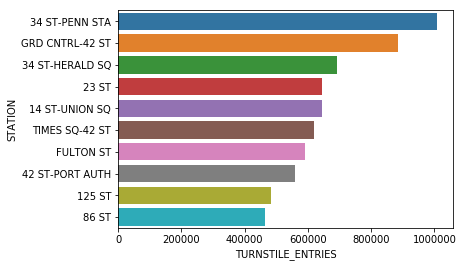

In [285]:
# Weekly rates
week_rates = data.groupby(by=['STATION'])['TURNSTILE_ENTRIES'].sum().reset_index().sort_values(by='TURNSTILE_ENTRIES', ascending=False)
display(week_rates.head(10))
sns.barplot(x='TURNSTILE_ENTRIES', y='STATION', orient='h', data=week_rates.head(10))

In [276]:
# Daily rates
rates = data.groupby(by=['STATION', 'DATE'])['TURNSTILE_ENTRIES'].sum().reset_index()
rates['WEEKDAY'] = rates['DATE'].dt.day_name()

In [277]:
rates.head()

,STATION,DATE,TURNSTILE_ENTRIES,DAY
0,1 AV,2018-06-16,14160.0,Saturday
1,1 AV,2018-06-17,14290.0,Sunday
2,1 AV,2018-06-18,19705.0,Monday
3,1 AV,2018-06-19,19830.0,Tuesday
4,1 AV,2018-06-20,22019.0,Wednesday


In [278]:
top_stations = rates.sort_values(by='TURNSTILE_ENTRIES', ascending=False)
top_10_stations = top_stations[top_stations['DATE'] == '06/21/2018'].head(10)['STATION'].unique()
top_10_stations

array(['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST',
       'TIMES SQ-42 ST', '14 ST-UNION SQ', 'FULTON ST', '42 ST-PORT AUTH',
       '125 ST', '86 ST'], dtype=object)

In [281]:
f = (top_stations['STATION'].isin(top_10_stations))
top_ten = top_stations[f]
top_ten.head()

,STATION,DATE,TURNSTILE_ENTRIES,DAY
416,34 ST-PENN STA,2018-06-21,180519.0,Thursday
415,34 ST-PENN STA,2018-06-20,177323.0,Wednesday
414,34 ST-PENN STA,2018-06-19,174704.0,Tuesday
413,34 ST-PENN STA,2018-06-18,173279.0,Monday
417,34 ST-PENN STA,2018-06-22,166459.0,Friday


In [293]:
top_ten2 = (top_ten.pivot(index='STATION', columns='DAY', values='TURNSTILE_ENTRIES'))
top_ten2

DAY,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
STATION,,,,,,,
125 ST,78800.0,74628.0,46524.0,46377.0,79801.0,77382.0,78510.0
14 ST-UNION SQ,108292.0,96469.0,59243.0,57411.0,106881.0,105403.0,110782.0
23 ST,111867.0,101265.0,40591.0,38669.0,119122.0,115093.0,118262.0
34 ST-HERALD SQ,115742.0,109757.0,53959.0,56132.0,121497.0,116197.0,120227.0
34 ST-PENN STA,166459.0,173279.0,63852.0,72019.0,180519.0,174704.0,177323.0
42 ST-PORT AUTH,91097.0,91810.0,46949.0,52092.0,95107.0,91183.0,92733.0
86 ST,75650.0,71945.0,39061.0,36415.0,79436.0,79674.0,81347.0
FULTON ST,101021.0,96946.0,40019.0,35593.0,105788.0,104135.0,106289.0
GRD CNTRL-42 ST,148921.0,152844.0,48947.0,46727.0,163445.0,162427.0,161895.0


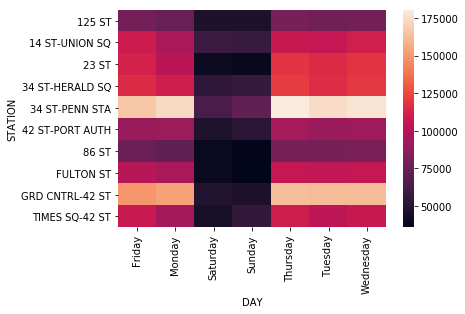

In [294]:
sns.heatmap(top_ten2)

In [ ]:
cols = ['Station', 'Day', 'People']
rates = pd.DataFrame

In [73]:
for station in sorted(data['STATION'].unique()):
    print(station)

1 AV
103 ST
103 ST-CORONA
104 ST
110 ST
111 ST
116 ST
116 ST-COLUMBIA
121 ST
125 ST
135 ST
137 ST CITY COL
138/GRAND CONC
14 ST
14 ST-UNION SQ
145 ST
149/GRAND CONC
14TH STREET
15 ST-PROSPECT
155 ST
157 ST
161/YANKEE STAD
167 ST
168 ST
169 ST
170 ST
174 ST
174-175 STS
175 ST
176 ST
18 AV
18 ST
181 ST
182-183 STS
183 ST
190 ST
191 ST
2 AV
20 AV
207 ST
21 ST
21 ST-QNSBRIDGE
215 ST
219 ST
225 ST
23 ST
231 ST
233 ST
238 ST
25 AV
25 ST
28 ST
3 AV
3 AV 138 ST
3 AV-149 ST
30 AV
33 ST
33 ST-RAWSON ST
34 ST-HERALD SQ
34 ST-HUDSON YD
34 ST-PENN STA
36 AV
36 ST
39 AV
4 AV-9 ST
40 ST LOWERY ST
42 ST-BRYANT PK
42 ST-PORT AUTH
45 ST
46 ST
46 ST BLISS ST
47-50 STS ROCK
49 ST
4AV-9 ST
5 AV/53 ST
5 AV/59 ST
5 AVE
50 ST
51 ST
52 ST
53 ST
55 ST
57 ST
57 ST-7 AV
59 ST
59 ST COLUMBUS
6 AV
61 ST WOODSIDE
63 DR-REGO PARK
65 ST
66 ST-LINCOLN
67 AV
68ST-HUNTER CO
69 ST
7 AV
71 ST
72 ST
72 ST-2 AVE
74 ST-BROADWAY
75 AV
75 ST-ELDERTS
77 ST
79 ST
8 AV
8 ST-NYU
80 ST
81 ST-MUSEUM
82 ST-JACKSON H
85 ST-FOREST PK
86

### Duplicate stations? Investigate
- 103 ST, 103 ST-CORONA
- 14 ST, 14 ST-UNION SQ, 14TH STREET
- 182-183 STS, 183 ST
- 21 ST, 21 ST-QNSBRIDGE
- 57 ST, 57 ST-7 AV
- 86 ST, 86 ST-2 AVE
- 96 ST, 96 ST-2 AVE
- BEVERLEY ROAD, BEVERLY RD
- BROADWAY, BROADWAY JCT
- JAMAICA CENTER, JFK JAMAICA CT1
- NEW LOTS, NEW LOTS AV
- PATH NEW WTC, PATH WTC 2
- VAN SICLEN AV, VAN SICLEN AVE

Field Description

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXITS    = The cumulative exit register value for a device

Example:
The data below shows the entry/exit register values for one turnstile at control area (A002) from 09/27/14 at 00:00 hours to 09/29/14 at 00:00 hours

C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS

A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,09-27-14,00:00:00,REGULAR,0004800073,0001629137

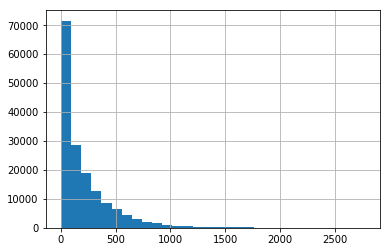

In [129]:
data[(data['ENTRIES_DIFF'] < 3000) & (data['ENTRIES_DIFF'] > 0)]['ENTRIES_DIFF'].hist(bins=30)

In [44]:
filtered_data = data[(data['ENTRIES_DIFF'] < 10000) & (data['ENTRIES_DIFF'] > 0)]

In [106]:
filtered_data.sort_values(by=['ENTRY_RATE'], ascending=False).head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,TIME_DELTA,ENTRIES_DIFF,EXITS_DIFF,HOURS,ENTRY_RATE
132651,R151,R033,00-00-07,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/20/2018,13:27:11,RECOVR AUD,124021,80979,2018-06-20 13:27:11,00:00:21,16.0,4.0,0.005833,2742.857143
132697,R151,R033,00-00-08,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/20/2018,13:27:11,RECOVR AUD,6891030,2212381,2018-06-20 13:27:11,00:00:21,14.0,7.0,0.005833,2400.000000
132605,R151,R033,00-00-06,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/20/2018,13:27:10,RECOVR AUD,7350761,8983088,2018-06-20 13:27:10,00:00:20,10.0,15.0,0.005556,1800.000000
132375,R151,R033,00-00-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/20/2018,13:27:10,RECOVR AUD,1717114208,320024472,2018-06-20 13:27:10,00:00:20,7.0,4.0,0.005556,1260.000000
132607,R151,R033,00-00-06,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/20/2018,13:28:33,RECOVR AUD,7350764,8983096,2018-06-20 13:28:33,00:00:23,8.0,10.0,0.006389,1252.173913


In [47]:
data['DESC'].value_counts()

REGULAR       196058
RECOVR AUD       628
Name: DESC, dtype: int64

In [90]:
station_data = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')

In [91]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
Remote       768 non-null object
Booth        768 non-null object
Station      768 non-null object
Line Name    768 non-null object
Division     768 non-null object
dtypes: object(5)
memory usage: 30.1+ KB


In [112]:
station_data[station_data['Station'] == '42 ST-TIMES SQ'].nunique()

Remote       2
Booth        9
Station      1
Line Name    2
Division     2
dtype: int64

In [113]:
data[data['STATION'] == 'TIMES SQ-42 ST'].sample(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
131854,R147,R033,04-00-06,TIMES SQ-42 ST,1237ACENQRS,IRT,06/18/2018,16:00:00,REGULAR,13204413,3046513
131340,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/17/2018,00:00:00,REGULAR,5355190,2405010
131623,R147,R033,04-00-00,TIMES SQ-42 ST,1237ACENQRS,IRT,06/22/2018,04:00:00,REGULAR,16763700,15063095
131197,R143,R032,02-03-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/21/2018,04:00:00,REGULAR,1713159780,1158896238
2628,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/20/2018,04:00:00,REGULAR,7878189,9500181
132275,R148,R033,01-06-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/18/2018,20:00:00,REGULAR,68123448,17134129
132294,R148,R033,01-06-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/22/2018,00:00:00,REGULAR,68128889,17138100
2904,A021,R032,01-00-07,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/17/2018,04:00:00,REGULAR,2273877,4025975
131272,R145,R032,00-00-00,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/19/2018,16:00:00,REGULAR,1886792,5793827
132022,R148,R033,01-00-01,TIMES SQ-42 ST,1237ACENQRSW,IRT,06/18/2018,16:00:00,REGULAR,1892593357,1427879616


In [144]:
times_sq = data[data['STATION'] == 'TIMES SQ-42 ST']
display(times_sq[times_sq['UNIT'] == 'R032'].nunique())
display(times_sq[times_sq['UNIT'] == 'R033'].nunique())
#display(times_sq[times_sq['LINENAME'] == '1237ACENQRS'].nunique())

C/A                3
UNIT               1
SCP               24
STATION            1
LINENAME           2
DIVISION           2
DATE               7
TIME               6
DESC               1
ENTRIES         1007
EXITS           1008
TIMESTAMP         42
TIME_DELTA         1
ENTRIES_DIFF     458
EXITS_DIFF       535
HOURS              1
ENTRY_RATE       458
dtype: int64

C/A                3
UNIT               1
SCP               26
STATION            1
LINENAME           2
DIVISION           1
DATE               7
TIME              15
DESC               2
ENTRIES         1053
EXITS           1032
TIMESTAMP         51
TIME_DELTA        15
ENTRIES_DIFF     624
EXITS_DIFF       517
HOURS             15
ENTRY_RATE       653
dtype: int64

In [145]:
times_sq

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,TIME_DELTA,ENTRIES_DIFF,EXITS_DIFF,HOURS,ENTRY_RATE
2603,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,00:00:00,REGULAR,7867845,9486124,2018-06-16 00:00:00,NaT,NaN,NaN,NaN,NaN
2604,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,04:00:00,REGULAR,7867948,9486179,2018-06-16 04:00:00,04:00:00,103.0,55.0,4.000000,25.750000
2605,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,08:00:00,REGULAR,7868020,9486298,2018-06-16 08:00:00,04:00:00,72.0,119.0,4.000000,18.000000
2606,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,12:00:00,REGULAR,7868283,9486859,2018-06-16 12:00:00,04:00:00,263.0,561.0,4.000000,65.750000
2607,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,16:00:00,REGULAR,7868687,9487505,2018-06-16 16:00:00,04:00:00,404.0,646.0,4.000000,101.000000
2608,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/16/2018,20:00:00,REGULAR,7869131,9488189,2018-06-16 20:00:00,04:00:00,444.0,684.0,4.000000,111.000000
2609,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/17/2018,00:00:00,REGULAR,7869466,9488543,2018-06-17 00:00:00,04:00:00,335.0,354.0,4.000000,83.750000
2610,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/17/2018,04:00:00,REGULAR,7869574,9488587,2018-06-17 04:00:00,04:00:00,108.0,44.0,4.000000,27.000000
2611,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/17/2018,08:00:00,REGULAR,7869619,9488656,2018-06-17 08:00:00,04:00:00,45.0,69.0,4.000000,11.250000
2612,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,BMT,06/17/2018,12:00:00,REGULAR,7869812,9489133,2018-06-17 12:00:00,04:00:00,193.0,477.0,4.000000,48.250000


In [111]:
sorted(station_data['Station'].unique())

['1 AVE',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '110 ST-CATHEDRL',
 '110 ST-CPN',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST-CITY COL',
 '138 ST-3 AVE',
 '138 ST-GR CONC',
 '14 ST',
 '14 ST-6 AVE',
 '14 ST-UNION SQ',
 '145 ST',
 '148 ST-LENOX',
 '149 ST-3 AVE',
 '149 ST-GR CONC',
 '14TH STREET',
 '15 ST-PROSPECT',
 '155 ST',
 '157 ST',
 '161 ST-YANKEE',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST-BROADWAY',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 ST',
 '175 ST',
 '176 ST',
 '18 AVE',
 '18 ST',
 '181 ST',
 '182-183 ST',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AVE',
 '2 BDWY CUST SRV',
 '20 AVE',
 '207 ST',
 '21 ST',
 '215 ST',
 '219 ST',
 '22 AVE-BAY PKY',
 '225 ST',
 '23 ST',
 '23 ST-5 AVE',
 '23 ST-6 AVE',
 '231 ST',
 '233 ST',
 '238 ST',
 '242 ST',
 '25 AVE',
 '25 ST',
 '28 ST',
 '28 ST-BROADWAY',
 '3 AVE',
 '33 ST',
 '33 ST/RAWSON ST',
 '34 ST-HERALD SQ',
 '34 ST-PENN STA',
 '36 ST',
 '4 AVE',
 '40 ST-LOWERY ST',
 '42 ST-BRYANT PK',